# 数据集准备
## 上传数据集至OBS并下载
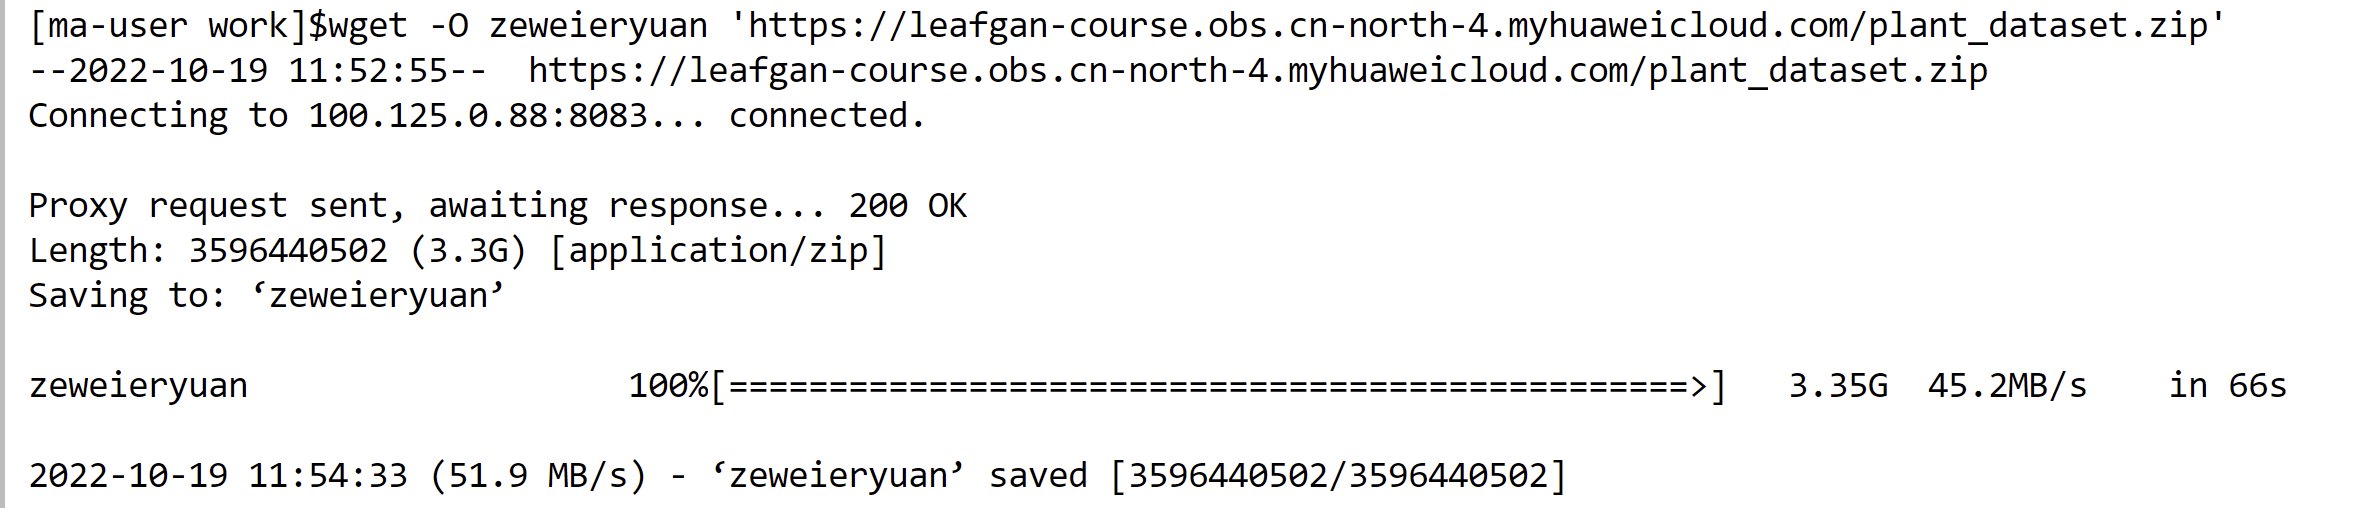
## 解压数据集

In [ ]:
!unzip zeweieryuan

In [1]:
# 导入相关库
import numpy as np 
import pandas as pd 

import os
import cv2
import time
import random
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style


from PIL import Image
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

import mindspore.dataset as de
from mindspore import dtype as mstype
import mindspore.dataset.vision as C
import mindspore.dataset.transforms as C2
from mindspore.dataset.vision import ImageBatchFormat
from mindspore.dataset.vision import AutoAugmentPolicy, Inter

## 数据集可视化

In [15]:
train_images_path ='./plant_dataset/train/images/'
test_images_path = './plant_dataset/test/images/'
val_images_path = './plant_dataset/val/images/'
train = pd.read_csv('./plant_dataset/train/train_label.csv', dtype=str)
test = pd.read_csv('./plant_dataset/test/test_label.csv', dtype=str)
train.head()

images              labels
0  a8ab965f868fc44c.jpg             healthy
1  a5d8924f7fad18a0.jpg             healthy
2  fab3f2b1c0d2a982.jpg                scab
3  d9b283cd98b19d13.jpg                scab
4  852979c129dde25d.jpg  frog_eye_leaf_spot

In [16]:
test.head()

images          labels
0  80bcfd9f60f06307.jpg  powdery_mildew
1  e062c0b63cd36f1b.jpg  powdery_mildew
2  df3b8800e2f892fa.jpg         complex
3  cff02d717850c0b7.jpg            scab
4  ac4fd4118a9e2df8.jpg            scab

In [17]:
train.shape

(3000, 2)

In [5]:
test.shape

(600, 2)

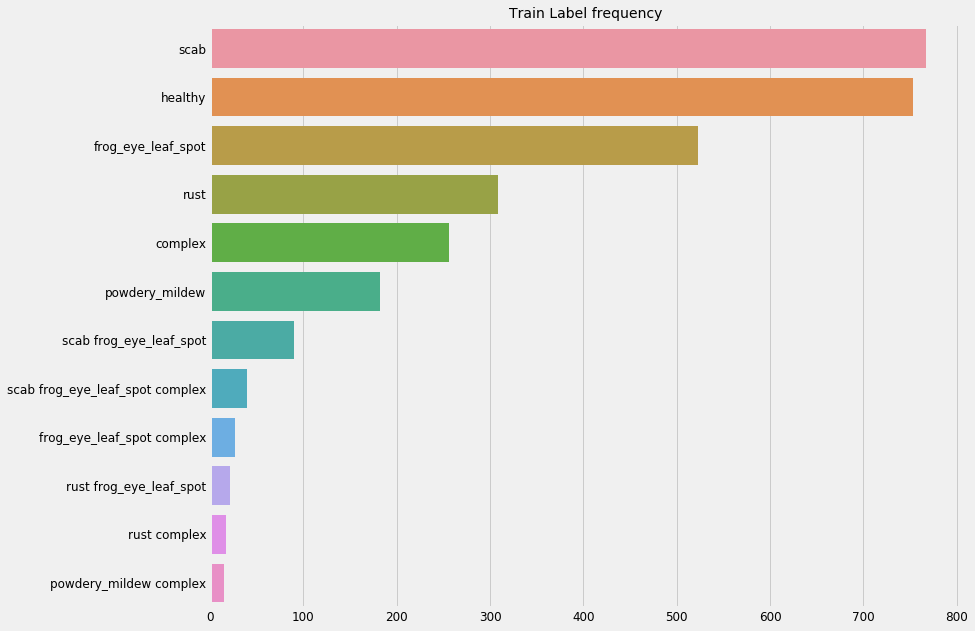

In [18]:
train_label_freq = train['labels'].apply(lambda s: str(s)).explode().value_counts().sort_values(ascending=False)

style.use("fivethirtyeight")
plt.figure(figsize=(12,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Train Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

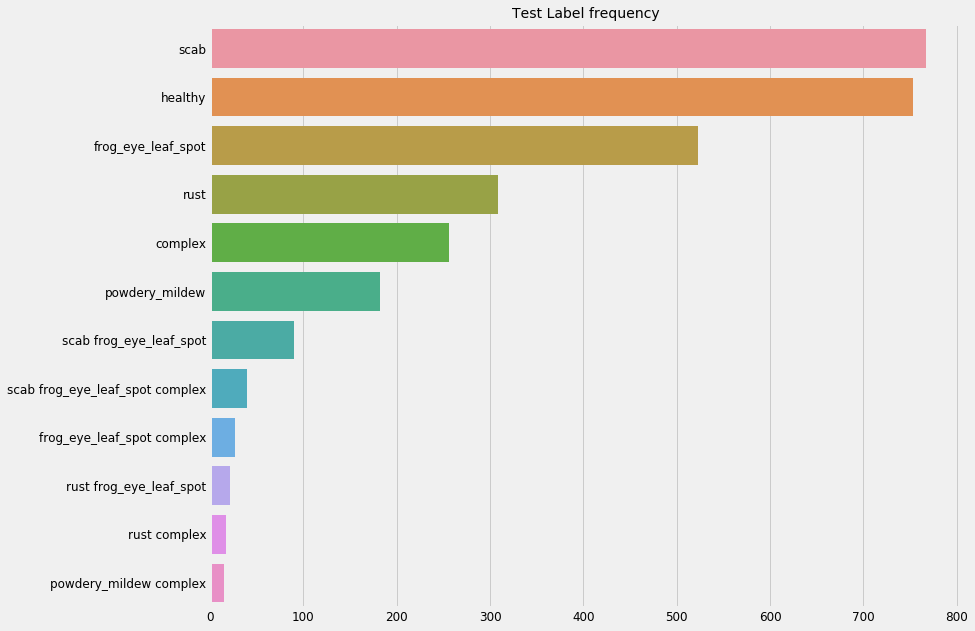

In [20]:
test_label_freq = test['labels'].apply(lambda s: str(s)).explode().value_counts().sort_values(ascending=False)

style.use("fivethirtyeight")
plt.figure(figsize=(12,10))
sns.barplot(y=label_freq.index.values, x=label_freq, order=label_freq.index)
plt.title("Test Label frequency", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [19]:
train_label_freq

scab                               767
healthy                            753
frog_eye_leaf_spot                 523
rust                               309
complex                            256
powdery_mildew                     182
scab frog_eye_leaf_spot             90
scab frog_eye_leaf_spot complex     40
frog_eye_leaf_spot complex          27
rust frog_eye_leaf_spot             21
rust complex                        17
powdery_mildew complex              15
Name: labels, dtype: int64

In [21]:
test_label_freq

scab                               160
healthy                            145
frog_eye_leaf_spot                 105
rust                                65
complex                             52
powdery_mildew                      34
scab frog_eye_leaf_spot             26
frog_eye_leaf_spot complex           5
scab frog_eye_leaf_spot complex      4
rust frog_eye_leaf_spot              2
rust complex                         2
Name: labels, dtype: int64

In [24]:
train['new_labels'] = train['labels'].apply(lambda s: [l for l in str(s).split()])
train.head()

images              labels            new_labels
0  a8ab965f868fc44c.jpg             healthy             [healthy]
1  a5d8924f7fad18a0.jpg             healthy             [healthy]
2  fab3f2b1c0d2a982.jpg                scab                [scab]
3  d9b283cd98b19d13.jpg                scab                [scab]
4  852979c129dde25d.jpg  frog_eye_leaf_spot  [frog_eye_leaf_spot]

In [25]:
test['new_labels'] = test['labels'].apply(lambda s: [l for l in str(s).split()])
test.head()

images          labels        new_labels
0  80bcfd9f60f06307.jpg  powdery_mildew  [powdery_mildew]
1  e062c0b63cd36f1b.jpg  powdery_mildew  [powdery_mildew]
2  df3b8800e2f892fa.jpg         complex         [complex]
3  cff02d717850c0b7.jpg            scab            [scab]
4  ac4fd4118a9e2df8.jpg            scab            [scab]

In [27]:
train_paths = [os.path.join(train_images_path, str(f)) for f in train['images']]
train_corresponding_labels = [f for f in train['new_labels']]

In [29]:
test_paths = [os.path.join(test_images_path, str(f)) for f in test['images']]
test_corresponding_labels = [f for f in test['new_labels']]

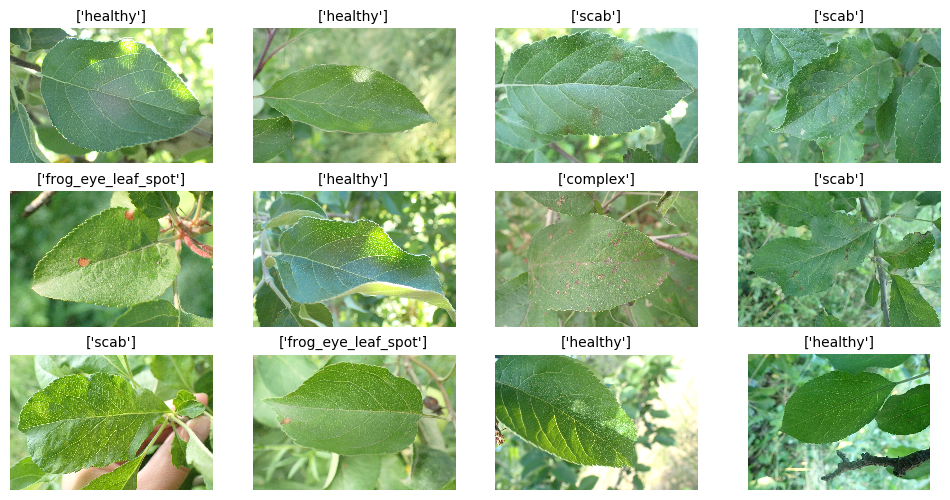

In [31]:
nobs = 14 
ncols = 4 
nrows = nobs//ncols 

style.use("default")
plt.figure(figsize=(12,2*nrows))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(train_paths[i]))
    plt.title(train_corresponding_labels[i], size=10)
    plt.axis('off')

## 数据集处理
对标签进行One-hot编码

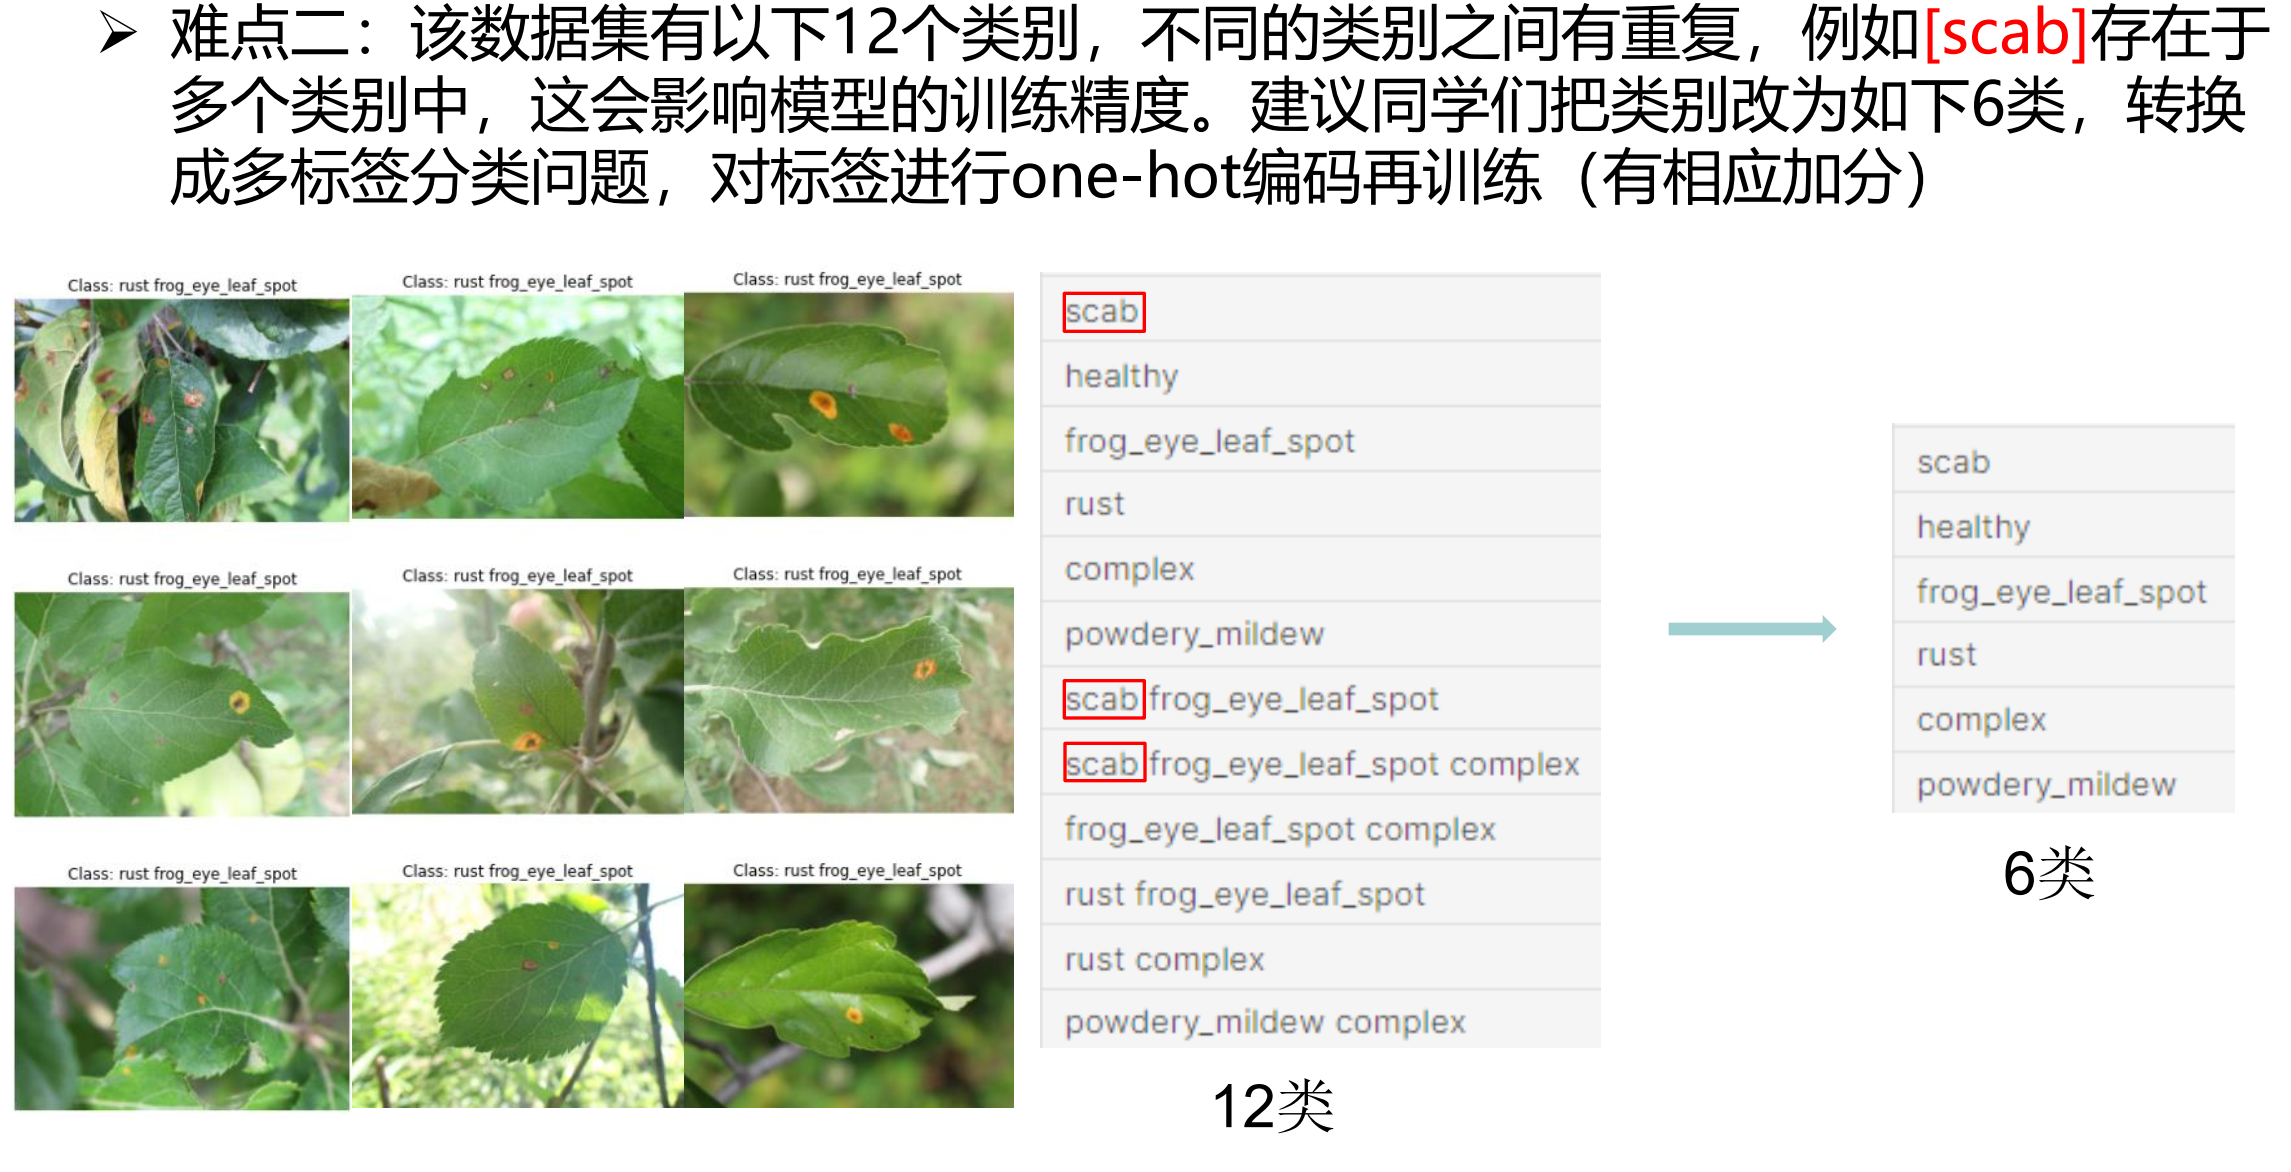

In [32]:
print("Labels:")
mlb = MultiLabelBinarizer()
mlb.fit(train['new_labels'])

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))


Labels:
0. complex
1. frog_eye_leaf_spot
2. healthy
3. powdery_mildew
4. rust
5. scab


In [33]:
df = pd.DataFrame(mlb.fit_transform(train['new_labels']),columns=mlb.classes_)
new_df = pd.concat([train,df],axis=1)

In [34]:
#生成多标签训练集
new_df

images              labels            new_labels  complex  \
0     a8ab965f868fc44c.jpg             healthy             [healthy]        0   
1     a5d8924f7fad18a0.jpg             healthy             [healthy]        0   
2     fab3f2b1c0d2a982.jpg                scab                [scab]        0   
3     d9b283cd98b19d13.jpg                scab                [scab]        0   
4     852979c129dde25d.jpg  frog_eye_leaf_spot  [frog_eye_leaf_spot]        0   
...                    ...                 ...                   ...      ...   
2995  eb8100abfd56157c.jpg             healthy             [healthy]        0   
2996  a89097fa5afb011b.jpg             healthy             [healthy]        0   
2997  f05ad49e5f0a0d4b.jpg  frog_eye_leaf_spot  [frog_eye_leaf_spot]        0   
2998  be7ef6d45ac18401.jpg             complex             [complex]        1   
2999  c5b420ff00b9fc2d.jpg                scab                [scab]        0   

      frog_eye_leaf_spot  healthy  powdery_mildew  rust  scab  
0                      0        1               0     0     0  
1                      0        1               0     0     0  
2                      0        0               0     0     1  
3                      0        0               0     0     1  
4                      1        0               0     0     0  
...                  ...      ...             ...   ...   ...  
2995                   0        1               0     0     0  
2996                   0        1               0     0     0  
2997                   1        0               0     0     0  
2998                   0        0               0     0     0  
2999                   0        0               0     0     1  

[3000 rows x 9 columns]

In [35]:
columns = list(mlb.classes_)
columns

['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']

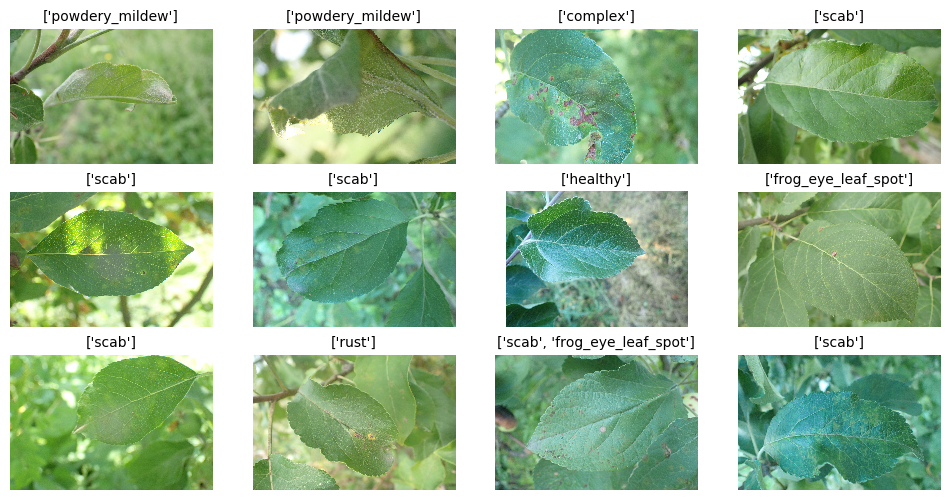

In [37]:
nobs = 14 
ncols = 4 
nrows = nobs//ncols 

style.use("default")
plt.figure(figsize=(12,2*nrows))
for i in range(nrows*ncols):
    ax = plt.subplot(nrows, ncols, i+1)
    plt.imshow(Image.open(test_paths[i]))
    plt.title(test_corresponding_labels[i], size=10)
    plt.axis('off')

In [38]:
print("Labels:")
mlb = MultiLabelBinarizer()
mlb.fit(test['new_labels'])

# Loop over all labels and show them
N_LABELS = len(mlb.classes_)
for (i, label) in enumerate(mlb.classes_):
    print("{}. {}".format(i, label))

Labels:
0. complex
1. frog_eye_leaf_spot
2. healthy
3. powdery_mildew
4. rust
5. scab


In [41]:
test_df = pd.DataFrame(mlb.fit_transform(test['new_labels']),columns=mlb.classes_)
test_new_df = pd.concat([test,test_df],axis=1)

In [42]:
test_new_df

images          labels        new_labels  complex  \
0    80bcfd9f60f06307.jpg  powdery_mildew  [powdery_mildew]        0   
1    e062c0b63cd36f1b.jpg  powdery_mildew  [powdery_mildew]        0   
2    df3b8800e2f892fa.jpg         complex         [complex]        1   
3    cff02d717850c0b7.jpg            scab            [scab]        0   
4    ac4fd4118a9e2df8.jpg            scab            [scab]        0   
..                    ...             ...               ...      ...   
595  cd1d4288f755f22a.jpg            scab            [scab]        0   
596  afac71d04350cf59.jpg            scab            [scab]        0   
597  e1a64386c9d6295f.jpg         complex         [complex]        1   
598  da8d3d93719038f1.jpg         complex         [complex]        1   
599  858d87da1e583e72.jpg            scab            [scab]        0   

     frog_eye_leaf_spot  healthy  powdery_mildew  rust  scab  
0                     0        0               1     0     0  
1                     0        0               1     0     0  
2                     0        0               0     0     0  
3                     0        0               0     0     1  
4                     0        0               0     0     1  
..                  ...      ...             ...   ...   ...  
595                   0        0               0     0     1  
596                   0        0               0     0     1  
597                   0        0               0     0     0  
598                   0        0               0     0     0  
599                   0        0               0     0     1  

[600 rows x 9 columns]

In [54]:
test_new_labels = test_new_df.drop(['labels', 'new_labels', 'healthy'], axis=1)

In [55]:
#生成多标签测试集
save = pd.DataFrame(test_new_labels) 
save.to_csv('./test_new_labels.csv',index=False,header=True)